<a href="https://colab.research.google.com/github/gtmray/Keras/blob/master/Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import itertools
import os
import shutil
import random
import glob
from google.colab import files

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num of GPUs: ", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num of GPUs:  1


In [4]:
pd.set_option('display.max_columns', 10)
sns.set()
plt.style.use('ggplot')

cols = ["Pregnancies" ,"Glucose" ,"BloodPressure" ,"SkinThickness" ,"Insulin" ,"BMI" ,"DiabetesPedigreeFunction" ,"Age" ,"Outcome"]
url = "https://gist.githubusercontent.com/ktisha/c21e73a1bd1700294ef790c56c8aec1f/raw/819b69b5736821ccee93d05b51de0510bea00294/pima-indians-diabetes.csv"
df = pd.read_csv(url, skiprows=9, names=cols)

target_col = 'Outcome'
X = df.drop(target_col, axis=1)
scaler = StandardScaler()
X = scaler.fit_transform(X)
y = df[target_col]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
model = Sequential([
                    Dense(units=12, input_dim = 8, activation = 'relu'),
                    Dense(units=16, input_shape=(1, ), activation='relu'),
                    Dense(units=32, activation='relu'),
                    Dense(units=2, activation='softmax')
])
#model.summary()
model.compile(optimizer=SGD(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(x=X_train, y=y_train, validation_split=0.1, batch_size=5, epochs=10, shuffle=True, verbose=2)
prediction_proba = model.predict(x=X_test, batch_size=5, verbose=0)
prediction = np.argmax(prediction_proba, axis=-1)
print((y_test==prediction).mean())

SAVING AND LOADING
 THE MODEL

In [ ]:
####USING .SAVE NORMAL

if os.path.isfile('/diabetes_model.h5') is False:
  model.save('/diabetes_model.h5') #Saving here saves architecture, weights, loss, optimizer, state of optimizer

from tensorflow.keras.models import load_model
new_model1 = load_model('/diabetes_model.h5')

#new_model1.summary()
new_model1.get_weights()
new_model1.optimizer

In [7]:
#SAVING IN JSON and yaml

json_string = model.to_json() #Only saves model architecture
yaml_string = model.to_yaml()

from tensorflow.keras.models import model_from_json, model_from_yaml
new_model2 = model_from_json(json_string)
#new_model2.summary()

new_model3 = model_from_yaml(yaml_string)
#new_model3.summary()

In [8]:
#SAVING ONLY WEIGHTS

if os.path.isfile('/diabetes_model_weights.h5') is False:
  model.save_weights('/diabetes_model_weights.h5') #Saving here saves architecture, weights, loss, optimizer, state of optimizer

model2 = Sequential([
                    Dense(units=12, input_dim = 8, activation = 'relu'),
                    Dense(units=16, input_shape=(1, ), activation='relu'),
                    Dense(units=32, activation='relu'),
                    Dense(units=2, activation='softmax')
])

model2.load_weights('/diabetes_model_weights.h5') #Shape must match

LOADING CATS AND DOGS IMAGES DATA FROM KAGGLE 

In [ ]:
if os.path.isdir('train') is False:
    ! pip install -q kaggle
    from google.colab import files
    files.upload()
    ! mkdir ~/.kaggle 
    ! cp kaggle.json ~/.kaggle/
    ! chmod 600 ~/.kaggle/kaggle.json
    ! kaggle datasets list
    ! kaggle competitions download -c 'dogs-vs-cats'
    ! mkdir train
    ! unzip train.zip -d train
    os.chdir('train/train')

In [11]:
if os.path.isdir('train/dog') is False:
  os.makedirs('train/dog')
  os.makedirs('train/cat')
  os.makedirs('valid/dog')
  os.makedirs('valid/cat')
  os.makedirs('test/dog')
  os.makedirs('test/cat')

  for c in random.sample(glob.glob('cat*'), 500):
    shutil.move(c, 'train/cat')
  for c in random.sample(glob.glob('dog*'), 500):
    shutil.move(c, 'train/dog')
  for c in random.sample(glob.glob('cat*'), 100):
    shutil.move(c, 'valid/cat')
  for c in random.sample(glob.glob('dog*'), 100):
    shutil.move(c, 'valid/dog')
  for c in random.sample(glob.glob('cat*'), 50):
    shutil.move(c, 'test/cat')
  for c in random.sample(glob.glob('dog*'), 50):
    shutil.move(c, 'test/dog')  

os.chdir('../../') #Go back to two directories

DATA PREPROCESSING


In [12]:
train_path = '/content/train/train/train'
valid_path = '/content/train/train/valid'
test_path = '/content/train/train/test'

train_batches = ImageDataGenerator(preprocessing_function=keras.applications.vgg16.preprocess_input).flow_from_directory(directory=train_path, target_size=(224, 224), classes=['cat', 'dog'], batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=keras.applications.vgg16.preprocess_input).flow_from_directory(directory=valid_path, target_size=(224, 224), classes=['cat', 'dog'], batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=keras.applications.vgg16.preprocess_input).flow_from_directory(directory=test_path, target_size=(224, 224), classes=['cat', 'dog'], batch_size=10, shuffle=False)


Found 1000 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


CREATING A CNN MODEL


In [13]:
model = Sequential([
                    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)),
                    MaxPool2D(pool_size=(2, 2), strides=2),
                    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
                    MaxPool2D(pool_size=(2, 2), strides=2),
                    Flatten(),
                    Dense(units=2, activation='softmax')
])

In [ ]:
model.summary()

TRAINING THE MODEL

In [15]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.fit(x=train_batches, validation_data=valid_batches, epochs=10, verbose=2)

In [12]:
def plot_confusion_matrix(batch_to_pred):
  preds = model.predict(x=batch_to_pred)
  y_preds = np.argmax(preds, axis=-1)
  y_true = batch_to_pred.classes
  confuse = confusion_matrix(y_true, y_preds)    
  sns.heatmap(pd.DataFrame(confuse), annot=True, cmap='viridis', fmt='g')
  plt.tight_layout()
  plt.xlabel('Predicted label')
  plt.ylabel('Actual label')
  plt.title('CONFUSION MATRIX')
  plt.show()

#plot_confusion_matrix(test_batches)

VGG16 MODEL

In [ ]:
#vgg is large (553 MB)
vgg16_model = tf.keras.applications.vgg16.VGG16()
#vgg16_model.summary()

In [ ]:
model = Sequential()
for layer in vgg16_model.layers[:-1]: #Except last layer
  model.add(layer)

for layer in model.layers: #Avoiding training layers
  layer.trainable=False

model.add(Dense(units=2, activation='softmax')) #Adding custom last layer
#model.summary()

In [31]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(x=train_batches, validation_data=valid_batches, epochs=5, verbose=2)

Epoch 1/5
100/100 - 8s - loss: 0.1279 - accuracy: 0.9590 - val_loss: 0.0616 - val_accuracy: 0.9850
Epoch 2/5
100/100 - 8s - loss: 0.0387 - accuracy: 0.9870 - val_loss: 0.0704 - val_accuracy: 0.9700
Epoch 3/5
100/100 - 8s - loss: 0.0112 - accuracy: 0.9950 - val_loss: 0.0286 - val_accuracy: 0.9950
Epoch 4/5
100/100 - 8s - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.0342 - val_accuracy: 0.9850
Epoch 5/5
100/100 - 8s - loss: 4.1479e-04 - accuracy: 1.0000 - val_loss: 0.0280 - val_accuracy: 0.9900


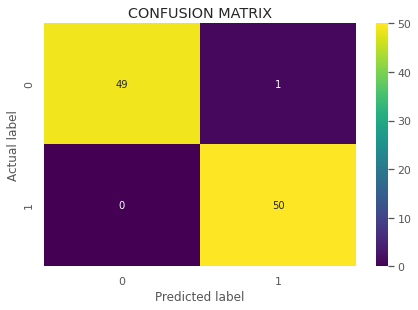

In [32]:
plot_confusion_matrix(test_batches)

MobileNET MODEL


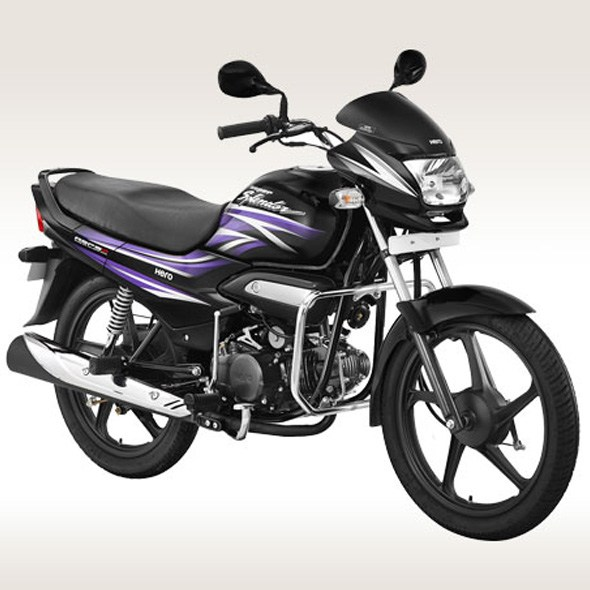

In [42]:
#MobileNET is small(17 MB)
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import imagenet_utils
mobile = tf.keras.applications.mobilenet.MobileNet()

def prepare_image(file): #According to mobilenet model

  img_path = '/content/'
  img = image.load_img(img_path + file, target_size=(224, 224))
  img_array = image.img_to_array(img)
  img_array_expanded_dims = np.expand_dims(img_array, axis=0)
  return tf.keras.applications.mobilenet.preprocess_input(img_array_expanded_dims) #RBG values scaled to -1 to 1

from IPython.display import Image
Image(filename='/content/bike.jpg', width=200, height=150)

In [43]:
preprocessed_image = prepare_image('bike.jpg')
predictions = mobile.predict(preprocessed_image)
results = imagenet_utils.decode_predictions(predictions)
results

[[('n03791053', 'motor_scooter', 0.5605087),
  ('n03785016', 'moped', 0.43232942),
  ('n03127747', 'crash_helmet', 0.0032599687),
  ('n03208938', 'disk_brake', 0.0018735447),
  ('n04482393', 'tricycle', 0.0006502507)]]

LOADING AND PREPROCESSING SIGN LANGUAGE DATASET

In [5]:
if os.path.isdir('Sign-Language-Digits-Dataset') is False:
    !git clone https://github.com/ardamavi/Sign-Language-Digits-Dataset

Cloning into 'Sign-Language-Digits-Dataset'...
remote: Enumerating objects: 2089, done.
remote: Total 2089 (delta 0), reused 0 (delta 0), pack-reused 2089
Receiving objects: 100% (2089/2089), 15.07 MiB | 25.84 MiB/s, done.
Resolving deltas: 100% (658/658), done.


In [6]:
os.chdir('/content/Sign-Language-Digits-Dataset/Dataset')
if os.path.isdir('train/0/') is False:
  os.mkdir('train')
  os.mkdir('valid')
  os.mkdir('test')

  for i in range(0, 10):
    shutil.move(f'{i}','train')
    os.mkdir(f'valid/{i}')
    os.mkdir(f'test/{i}')

    valid_samples = random.sample(os.listdir(f'train/{i}'), 30)
    for j in valid_samples:
      shutil.move(f'train/{i}/{j}', f'valid/{i}')

    test_samples = random.sample(os.listdir(f'train/{i}'), 5)
    for k in test_samples:
      shutil.move(f'train/{i}/{k}', f'test/{i}')  
os.chdir('../..')


In [7]:
train_path = '/content/Sign-Language-Digits-Dataset/Dataset/train'
valid_path = '/content/Sign-Language-Digits-Dataset/Dataset/valid'
test_path = '/content/Sign-Language-Digits-Dataset/Dataset/test'

In [8]:
train_batches = ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input).flow_from_directory(directory=train_path, target_size=(224, 224), batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input).flow_from_directory(directory=valid_path, target_size=(224, 224), batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input).flow_from_directory(directory=test_path, target_size=(224, 224), batch_size=10, shuffle=False)

Found 1712 images belonging to 10 classes.
Found 300 images belonging to 10 classes.
Found 50 images belonging to 10 classes.


Modifying Mobilenet Model

In [9]:
from tensorflow.keras import Model
mobile = tf.keras.applications.mobilenet.MobileNet()
#mobile.summary()
x = mobile.layers[-6].output
output = Dense(units=10, activation='softmax')(x)
model = Model(inputs=mobile.input, outputs=output)

17227776/17225924 [==============================] - 0s 0us/step


In [10]:
for layer in model.layers[:-23]:
  layer.trainable=False
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(x=train_batches, validation_data=valid_batches, epochs=5, verbose=2)


Epoch 1/5
172/172 - 8s - loss: 0.3807 - accuracy: 0.8803 - val_loss: 0.8060 - val_accuracy: 0.8067
Epoch 2/5
172/172 - 8s - loss: 0.0716 - accuracy: 0.9772 - val_loss: 0.1053 - val_accuracy: 0.9533
Epoch 3/5
172/172 - 7s - loss: 0.0601 - accuracy: 0.9813 - val_loss: 0.2968 - val_accuracy: 0.9100
Epoch 4/5
172/172 - 7s - loss: 0.0513 - accuracy: 0.9860 - val_loss: 0.1280 - val_accuracy: 0.9500
Epoch 5/5
172/172 - 7s - loss: 0.0649 - accuracy: 0.9807 - val_loss: 0.0494 - val_accuracy: 0.9800


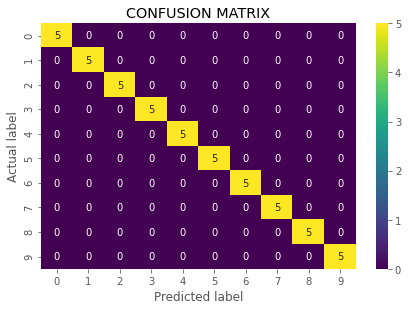

In [13]:
plt.style.use('ggplot')
plot_confusion_matrix(test_batches)

DATA AUGMENTATION

In [57]:
def plotImages(images_array):
  fig, axes = plt.subplots(1, 10, figsize=(20, 20))
  axes = axes.flatten()
  for img, ax in zip(images_array, axes):
    ax.imshow(img)
    ax.axis('off') #To turn off scales in images
  plt.tight_layout() #To remove gaps and spaces
  plt.show()

gen = ImageDataGenerator(rotation_range=10, width_shift_range=0.1, height_shift_range=0.1, shear_range=0.15, zoom_range=0.1,
                         channel_shift_range=10, horizontal_flip=True)

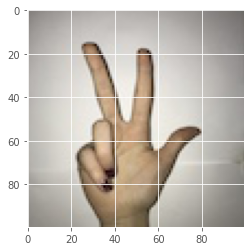

In [58]:
choosen_image = random.choice(os.listdir('/content/Sign-Language-Digits-Dataset/Dataset/test/3'))
image_path = '/content/Sign-Language-Digits-Dataset/Dataset/test/3/' + choosen_image

#Obtain image
image = np.expand_dims(plt.imread(image_path), 0) #Expand dimension from in row 
plt.imshow(image[0])

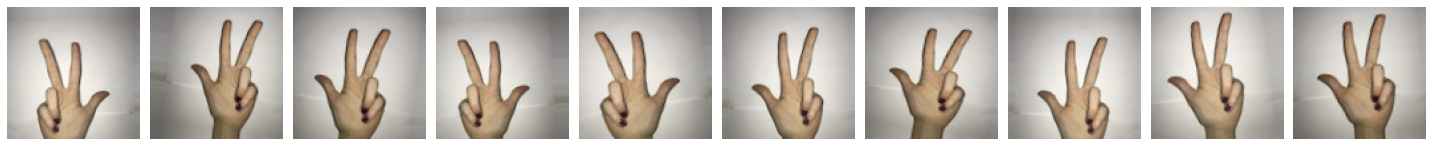

In [59]:
#Generate batches of augmente images from this image
aug_iter = gen.flow(image)

#Get 10 samples of augmented images
aug_images = [next(aug_iter)[0].astype(np.uint8) for i in range(10)]
plotImages(aug_images)